In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet

In [3]:
customers = pd.read_csv("/content/drive/MyDrive/Ajio/Ajio/customer.csv")
delivery = pd.read_csv("/content/drive/MyDrive/Ajio/Ajio/delivery.csv")
orders = pd.read_csv("/content/drive/MyDrive/Ajio/Ajio/orders.csv")  # Ensure date is parsed
products = pd.read_csv("/content/drive/MyDrive/Ajio/Ajio/products.csv")
ratings = pd.read_csv("/content/drive/MyDrive/Ajio/Ajio/ratings.csv")
returns = pd.read_csv("/content/drive/MyDrive/Ajio/Ajio/returns.csv")
transactions = pd.read_csv("/content/drive/MyDrive/Ajio/Ajio/transaction.csv")

In [4]:
customers.info()
delivery.info()
orders.info()
products.info()
ratings.info()
returns.info()
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   C_ID            10000 non-null  object
 1   C_Name          10000 non-null  object
 2   Gender          10000 non-null  object
 3   Age             10000 non-null  int64 
 4   City            10000 non-null  object
 5   State           10000 non-null  object
 6   Street_Address  10000 non-null  object
 7   Mobile          10000 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 625.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   DP_ID        5 non-null      object
 1   DP_name      5 non-null      object
 2   DP_Ratings   5 non-null      int64 
 3   Percent_Cut  5 non-null      int64 
dtypes: int64(2), object(2)
memory usage: 292.0+ bytes


In [5]:
customers.isnull().sum(), delivery.isnull().sum(), orders.isnull().sum(), products.isnull().sum(), ratings.isnull().sum(), returns.isnull().sum(), transactions.isnull().sum()

(C_ID              0
 C_Name            0
 Gender            0
 Age               0
 City              0
 State             0
 Street_Address    0
 Mobile            0
 dtype: int64,
 DP_ID          0
 DP_name        0
 DP_Ratings     0
 Percent_Cut    0
 dtype: int64,
 Or_ID         0
 C_ID          0
 P_ID          0
 Order_Date    0
 Order_Time    0
 Qty           0
 Coupon        0
 DP_ID         0
 Discount      0
 dtype: int64,
 P_ID            0
 P_Name          0
 Category        0
 Company_Name    0
 Gender          0
 Price           0
 dtype: int64,
 R_ID                       0
 Or_ID                      0
 Prod_Rating                0
 Delivery_Service_Rating    0
 dtype: int64,
 RT_ID            0
 Or_ID            0
 Reason           0
 Return_Refund    0
 Dates            0
 dtype: int64,
 Tr_ID               0
 Or_ID               0
 Transaction_Mode    0
 Reward              0
 dtype: int64)

In [6]:
orders_full = pd.merge(orders, customers, on='C_ID', how="left") \
                .merge(products, on='P_ID',how="left") \
                .merge(ratings, on='Or_ID',how="left") \
                .merge(returns, on='Or_ID',how="left") \
                .merge(transactions, on='Or_ID',how="left") \
                .merge(delivery, on='DP_ID',how="left")

## Sales & Customer Insights

In [7]:
# Calculate total sales and average order value
# Total sales calculation requires multiplying quantity by price and considering discount.
orders_full['Total_Price'] = orders_full['Qty'] * orders_full['Price']
orders_full['Discounted_Price'] = orders_full['Total_Price'] * (1 - orders_full['Discount'] / 100)

total_sales = orders_full['Discounted_Price'].sum()
average_order_value = orders_full['Discounted_Price'].mean()


print(f"Total Sales: ${total_sales:,.2f}")
print(f"Average Order Value: ${average_order_value:,.2f}")

Total Sales: $170,709,546.68
Average Order Value: $8,906.43



Top 10 Selling Products (by Quantity):
P_Name
Bootcut Poly-Cotton Light Blue Solid Jeans          160
Pleated Mesh Brown Colorblock Shorts                143
Slim Fit Poly-Cotton Washed Blue Patchwork Jeans    140
Graphic Rayon Black Embroidered T-Shirt             138
Zipper Merino Wool Charcoal Textured Sweater        136
Baja French Terry Dark Green Printed Hoodie         135
Single-Breasted Linen Gray Pinstripe Blazer         132
Athletic Twill Black Checkered Shorts               128
Crew Neck Knitted Navy Blue Geometric Sweater       120
Midi Rayon Gray Floral Dress                        119
Name: Qty, dtype: int64


/tmp/ipython-input-2009944025.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_selling_products.values, y=top_selling_products.index, palette='viridis')


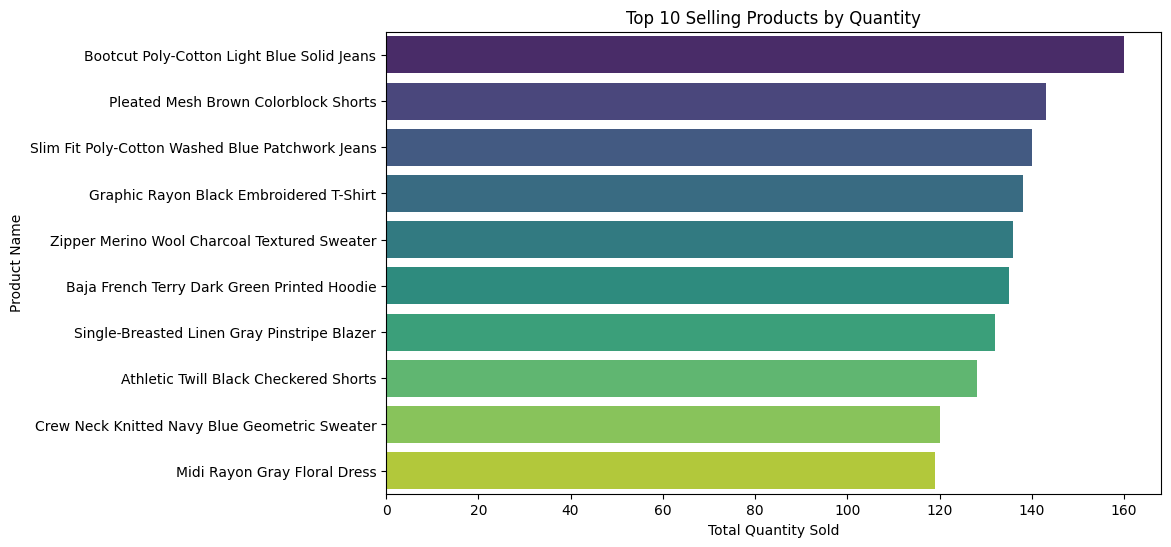

In [8]:
# Top selling products
top_selling_products = orders_full.groupby('P_Name')['Qty'].sum().sort_values(ascending=False).head(10)
print("\nTop 10 Selling Products (by Quantity):")
print(top_selling_products)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_selling_products.values, y=top_selling_products.index, palette='viridis')
plt.title('Top 10 Selling Products by Quantity')
plt.xlabel('Total Quantity Sold')
plt.ylabel('Product Name')
plt.show()


Top 10 Most Active Customers (by Number of Orders):
C_ID         C_Name         
CS_11008968  Tanish Bhavsar     7
CS_11007611  Vedhika Mane       6
CS_11007911  Leela Dani         6
CS_11005093  Vasudha Devan      6
CS_11008868  Wakeeta Bakshi     6
CS_11004286  Harsh Andra        5
CS_11007833  Indali Das         5
CS_11007761  Mitesh Raju        5
CS_11001754  Bishakha Khalsa    5
CS_11007700  Aarav Chaudry      5
Name: Or_ID, dtype: int64


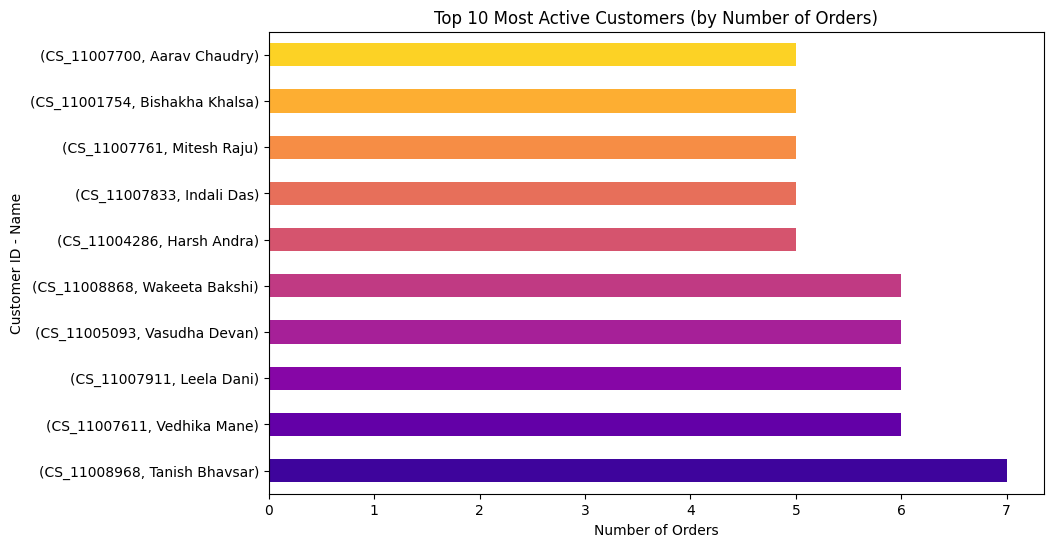

In [9]:
# Most active customers (by number of orders)
most_active_customers = orders_full.groupby(['C_ID', 'C_Name'])['Or_ID'].nunique().sort_values(ascending=False).head(10)
print("\nTop 10 Most Active Customers (by Number of Orders):")
print(most_active_customers)

plt.figure(figsize=(10, 6))
most_active_customers.plot(kind='barh', color=sns.color_palette('plasma', 10))
plt.title('Top 10 Most Active Customers (by Number of Orders)')
plt.xlabel('Number of Orders')
plt.ylabel('Customer ID - Name')
plt.show()

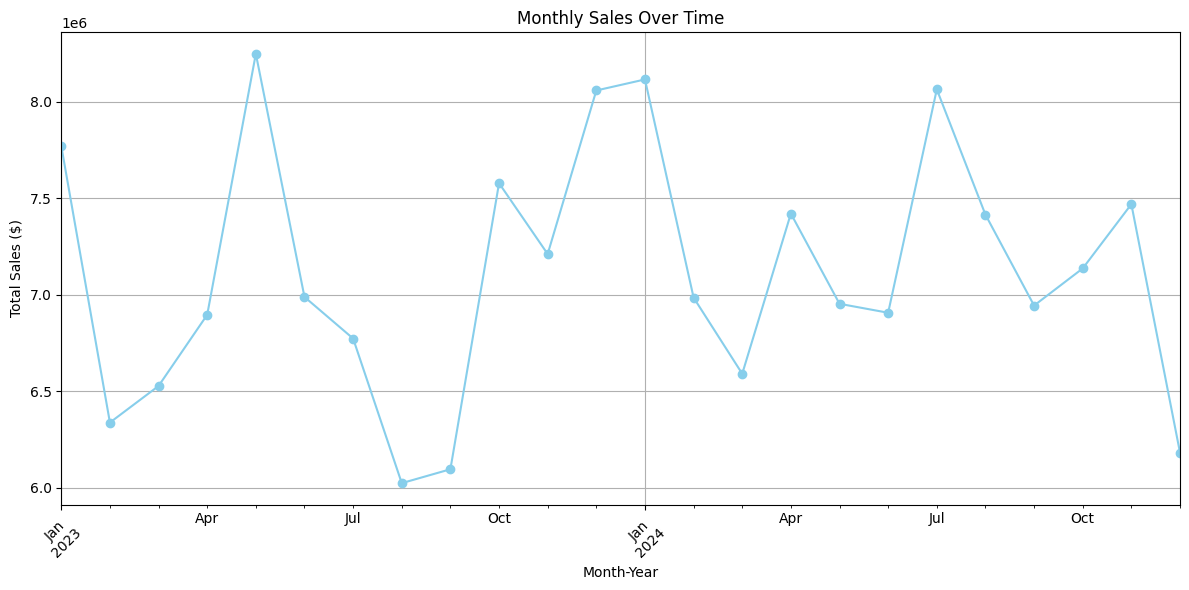

In [10]:
# Sales by month/year
orders_full['Order_Date'] = pd.to_datetime(orders_full['Order_Date'])
orders_full['Order_Month_Year'] = orders_full['Order_Date'].dt.to_period('M')

monthly_sales = orders_full.groupby('Order_Month_Year')['Discounted_Price'].sum()

plt.figure(figsize=(12, 6))
monthly_sales.plot(kind='line', marker='o', color='skyblue')
plt.title('Monthly Sales Over Time')
plt.xlabel('Month-Year')
plt.ylabel('Total Sales ($)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## Returns & Ratings


Return Reasons:
Reason
Late Delivery         1294
Wrong Item Shipped    1272
Defective Product     1241
Name: count, dtype: int64


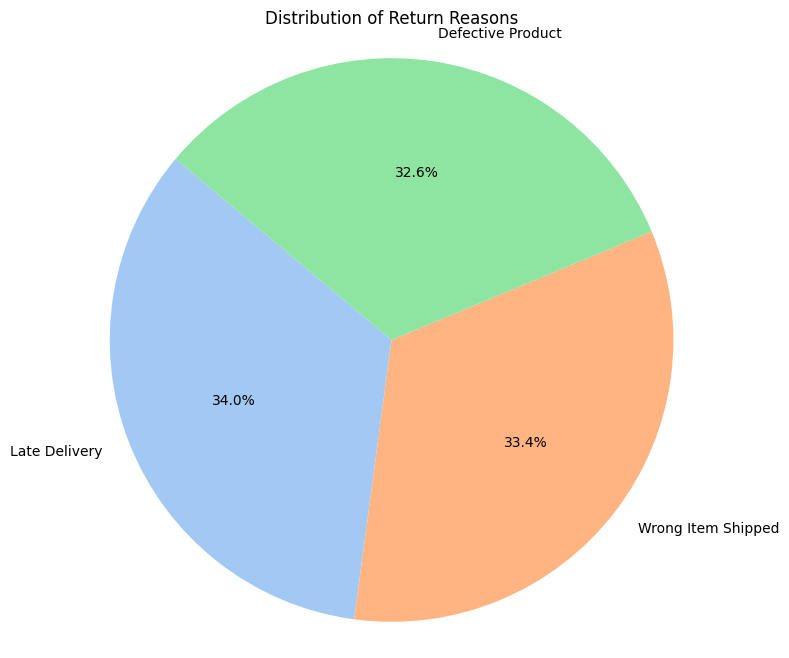

In [11]:
# Return reasons
return_reasons = orders_full['Reason'].value_counts()
print("\nReturn Reasons:")
print(return_reasons)

plt.figure(figsize=(8, 8))
plt.pie(return_reasons, labels=return_reasons.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Distribution of Return Reasons')
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


Top 10 Products with Highest Number of Returns:
P_Name
Pleated Rayon Gray Textured Skirt              24
Longline Rayon Gray Embroidered T-Shirt        16
Single-Breasted Linen Gray Pinstripe Blazer    13
Mermaid Linen Gray Striped Dress               12
Maxi Tulle Navy Blue Textured Skirt            12
Puffer Wool Gray Geometric Jacket              12
Zipper Fleece Black Checkered Sweater          12
Skinny Rigid Denim Olive Green Solid Jeans     12
A-Line Rayon Olive Green Printed Dress         12
Pencil Rayon Dark Green Geometric Skirt        11
Name: RT_ID, dtype: int64


/tmp/ipython-input-473371003.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=highest_return_products.values, y=highest_return_products.index, palette='rocket')


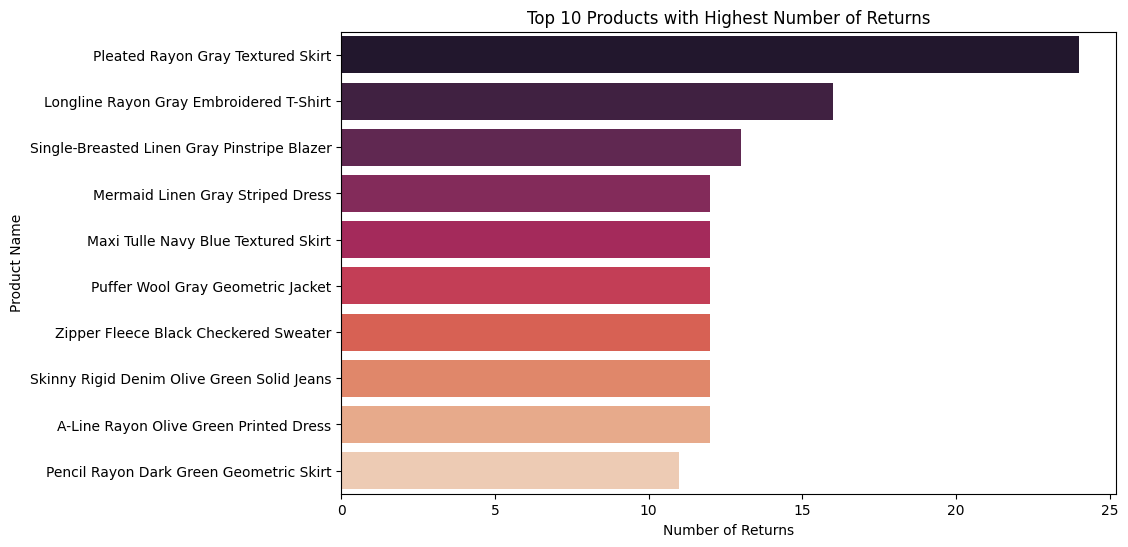

In [12]:
# Products with highest returns
products_with_returns = orders_full[orders_full['Reason'].notnull()]
highest_return_products = products_with_returns.groupby('P_Name')['RT_ID'].count().sort_values(ascending=False).head(10)
print("\nTop 10 Products with Highest Number of Returns:")
print(highest_return_products)

plt.figure(figsize=(10, 6))
sns.barplot(x=highest_return_products.values, y=highest_return_products.index, palette='rocket')
plt.title('Top 10 Products with Highest Number of Returns')
plt.xlabel('Number of Returns')
plt.ylabel('Product Name')
plt.show()


Average Product Rating by Category:
Category
Shirt      3.090705
Blazer     3.027237
Hoodie     3.008607
Jeans      3.007344
Skirt      2.997281
Dress      2.986561
Sweater    2.981754
Jacket     2.957065
T-Shirt    2.950627
Shorts     2.938089
Name: Prod_Rating, dtype: float64


/tmp/ipython-input-3896786162.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=average_product_rating_by_category.index, y=average_product_rating_by_category.values, palette='mako')


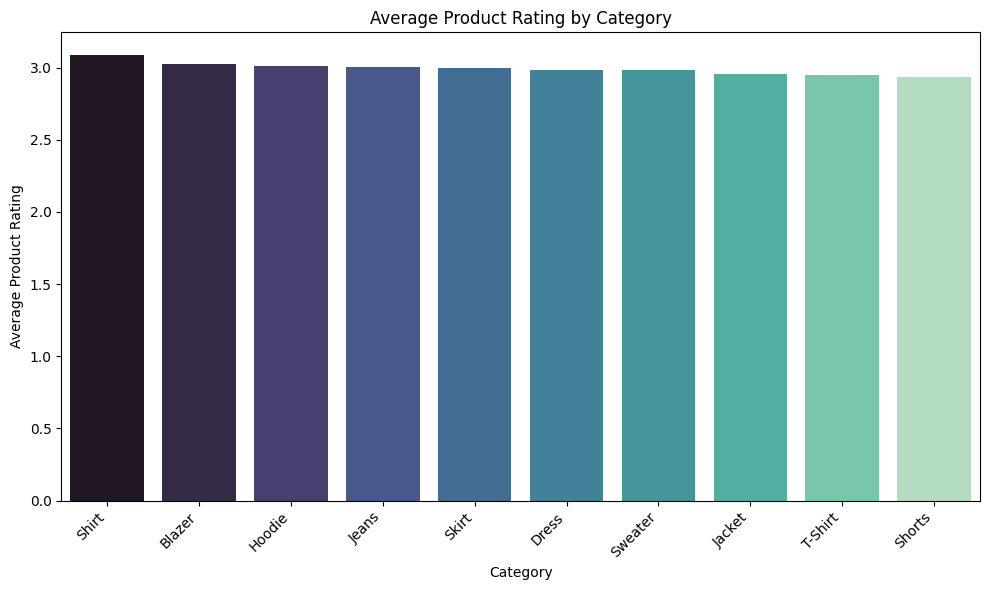

In [13]:
# Product ratings by category
orders_full['Prod_Rating'] = pd.to_numeric(orders_full['Prod_Rating'], errors='coerce')

average_product_rating_by_category = orders_full.groupby('Category')['Prod_Rating'].mean().sort_values(ascending=False)
print("\nAverage Product Rating by Category:")
print(average_product_rating_by_category)

plt.figure(figsize=(10, 6))
sns.barplot(x=average_product_rating_by_category.index, y=average_product_rating_by_category.values, palette='mako')
plt.title('Average Product Rating by Category')
plt.xlabel('Category')
plt.ylabel('Average Product Rating')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Payment & Delivery Patterns


Preferred Payment Methods:
Transaction_Mode
Net Banking    2826
Credit Card    2773
Wallet         2771
UPI            2758
Debit Card     2734
Name: count, dtype: int64


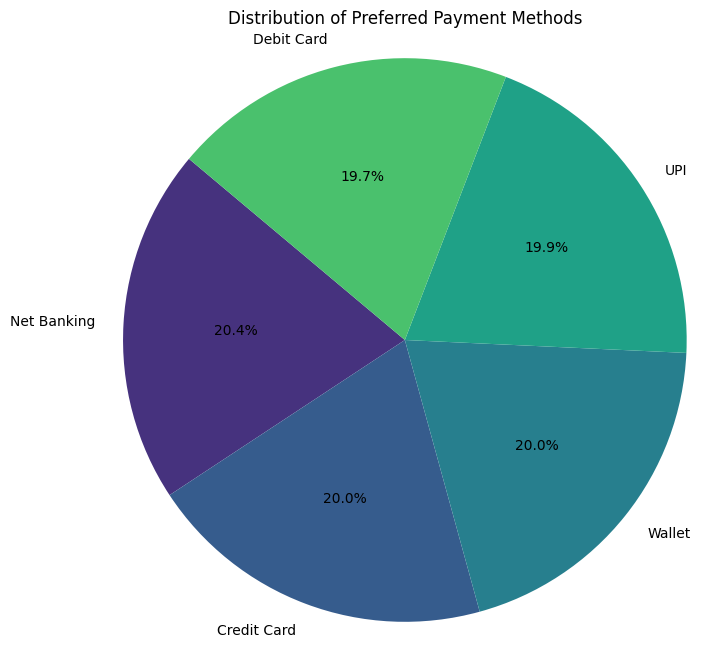

In [14]:
# Preferred payment methods
preferred_payment_methods = orders_full['Transaction_Mode'].value_counts()
print("\nPreferred Payment Methods:")
print(preferred_payment_methods)

plt.figure(figsize=(8, 8))
plt.pie(preferred_payment_methods, labels=preferred_payment_methods.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis'))
plt.title('Distribution of Preferred Payment Methods')
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


Average Delivery Service Rating by State:
State
Delhi             3.120253
Bihar             3.118439
Karnataka         3.103395
Tamil Nadu        3.075152
Gujarat           3.065777
Madhya Pradesh    3.055094
Uttar Pradesh     3.039474
Telangana         2.963710
West Bengal       2.952802
Rajasthan         2.942161
Name: Delivery_Service_Rating, dtype: float64


/tmp/ipython-input-2697009216.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=average_delivery_rating_by_state.values, y=average_delivery_rating_by_state.index, palette='cubehelix')


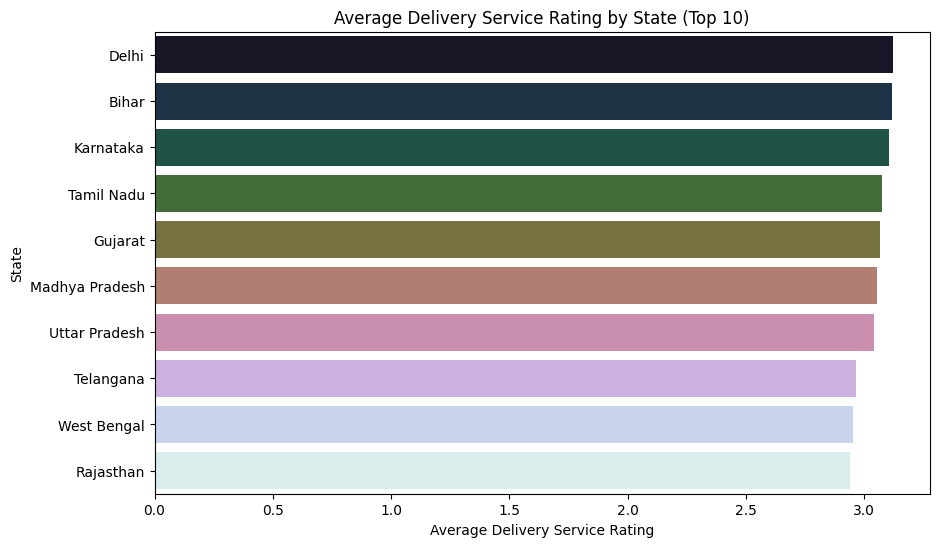

In [16]:
# However, we can analyze delivery service ratings by state as a proxy for delivery performance.)
# Ensure 'Delivery_Service_Rating' is treated as numeric, coercing errors
orders_full['Delivery_Service_Rating'] = pd.to_numeric(orders_full['Delivery_Service_Rating'], errors='coerce')

average_delivery_rating_by_state = orders_full.groupby('State')['Delivery_Service_Rating'].mean().sort_values(ascending=False).head(10) # Display top 10 states for clarity
print("\nAverage Delivery Service Rating by State:")
print(average_delivery_rating_by_state)

plt.figure(figsize=(10, 6))
sns.barplot(x=average_delivery_rating_by_state.values, y=average_delivery_rating_by_state.index, palette='cubehelix')
plt.title('Average Delivery Service Rating by State (Top 10)')
plt.xlabel('Average Delivery Service Rating')
plt.ylabel('State')
plt.show()


Return Rate by State:
State
Delhi             0.441038
West Bengal       0.428571
Maharashtra       0.413240
Uttar Pradesh     0.390047
Telangana         0.376218
Andhra Pradesh    0.373646
Tamil Nadu        0.367837
Gujarat           0.363636
Bihar             0.360784
Madhya Pradesh    0.359263
dtype: float64


/tmp/ipython-input-3085864171.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='Average_Delivery_Rating', y='Return_Rate', data=comparison_df, s=100, palette='viridis')


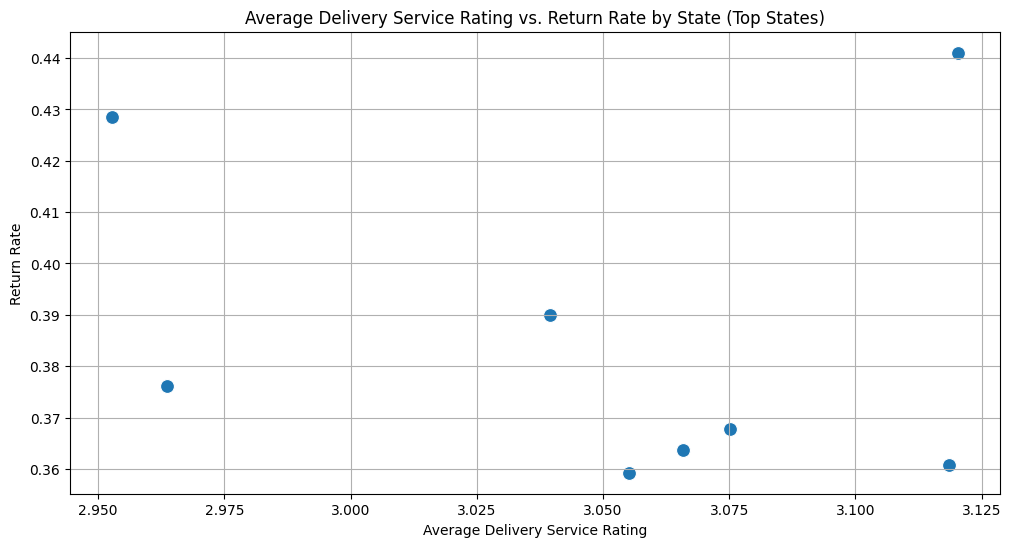

In [17]:
# Compare delay vs return rate (Again, direct delay data is missing. We can compare average delivery service rating with return rate by state.)

return_rate_by_state = orders_full.groupby('State')['Reason'].count() / orders_full.groupby('State')['Or_ID'].nunique()
return_rate_by_state = return_rate_by_state.sort_values(ascending=False).head(10) # Display top 10 states for clarity

print("\nReturn Rate by State:")
print(return_rate_by_state)

# Combine average delivery rating and return rate for comparison (Focusing on the top states from each analysis for a clearer visualization)
comparison_df = pd.DataFrame({'Average_Delivery_Rating': average_delivery_rating_by_state,
                              'Return_Rate': return_rate_by_state}).dropna() # Drop states not in both top lists

if not comparison_df.empty:
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='Average_Delivery_Rating', y='Return_Rate', data=comparison_df, s=100, palette='viridis')
    plt.title('Average Delivery Service Rating vs. Return Rate by State (Top States)')
    plt.xlabel('Average Delivery Service Rating')
    plt.ylabel('Return Rate')
    plt.grid(True)
    plt.show()
else:
    print("\nInsufficient data to compare delivery rating and return rate for the top states.")

In [18]:
# Create 'Total_Sale' column (already done in previous steps, but good to keep here for completeness)
orders_full['Total_Sale'] = orders_full['Qty'] * orders_full['Price']


# Create 'Is_Returned' column
orders_full['Is_Returned'] = orders_full['Reason'].apply(lambda x: 1 if pd.notnull(x) else 0)

# Monthly or weekly sales aggregation (already done in previous steps, but good to keep here for completeness)
orders_full['Order_Date'] = pd.to_datetime(orders_full['Order_Date'])
orders_full['Order_Month'] = orders_full['Order_Date'].dt.to_period('M')
monthly_sales_agg = orders_full.groupby('Order_Month')['Discounted_Price'].sum()

# Rating categories: high, medium, low
# Define rating bins and labels
rating_bins = [0, 3, 4, 5]
rating_labels = ['Low', 'Medium', 'High']

# Create 'Rating_Category' column for Product Ratings
orders_full['Prod_Rating'] = pd.to_numeric(orders_full['Prod_Rating'], errors='coerce') # Ensure numeric
orders_full['Prod_Rating_Category'] = pd.cut(orders_full['Prod_Rating'], bins=rating_bins, labels=rating_labels, right=True, include_lowest=True)

# Create 'Rating_Category' column for Delivery Service Ratings
orders_full['Delivery_Service_Rating'] = pd.to_numeric(orders_full['Delivery_Service_Rating'], errors='coerce') # Ensure numeric
orders_full['Delivery_Rating_Category'] = pd.cut(orders_full['Delivery_Service_Rating'], bins=rating_bins, labels=rating_labels, right=True, include_lowest=True)

# Display the first few rows with the new features
display(orders_full[['Or_ID', 'Total_Sale', 'Is_Returned', 'Order_Month', 'Prod_Rating_Category', 'Delivery_Rating_Category']].head())

,Or_ID,Total_Sale,Is_Returned,Order_Month,Prod_Rating_Category,Delivery_Rating_Category
0,OR_31000001,2300,1,2024-02,Low,Low
1,OR_31000002,3155,0,2024-01,Low,Medium
2,OR_31000002,3155,0,2024-01,High,High
3,OR_31000003,836,0,2024-09,NaN,NaN
4,OR_31000004,8470,1,2023-05,Low,Medium


## Predictive Modeling: Sales Forecasting

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxl6u6wes/1geprl1j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxl6u6wes/7byiwg36.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79947', 'data', 'file=/tmp/tmpxl6u6wes/1geprl1j.json', 'init=/tmp/tmpxl6u6wes/7byiwg36.json', 'output', 'file=/tmp/tmpxl6u6wes/prophet_modelg1t90kan/prophet_model-20250731155210.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:52:10 - cmdstanpy - INFO - Chain [1] start processing
I


Sales Forecast for the next 6 months:


,ds,yhat,yhat_lower,yhat_upper
25,2025-01-31,7.198588e+06,6.374985e+06,7.978186e+06
26,2025-02-28,7.204426e+06,6.352661e+06,8.017958e+06
27,2025-03-31,7.210888e+06,6.398883e+06,8.011922e+06
28,2025-04-30,7.217143e+06,6.396652e+06,7.998365e+06
29,2025-05-31,7.223606e+06,6.392330e+06,7.988122e+06


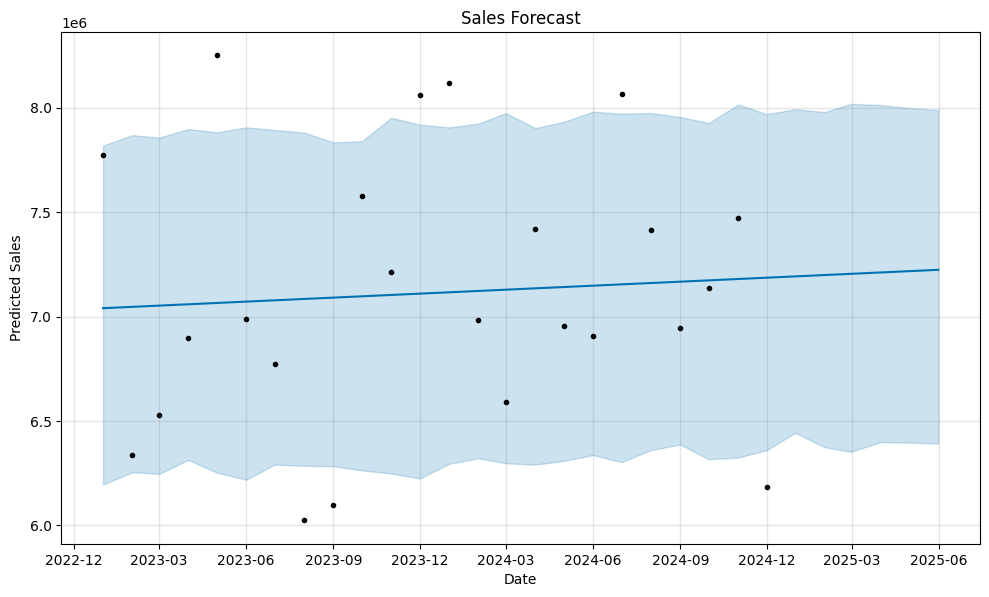

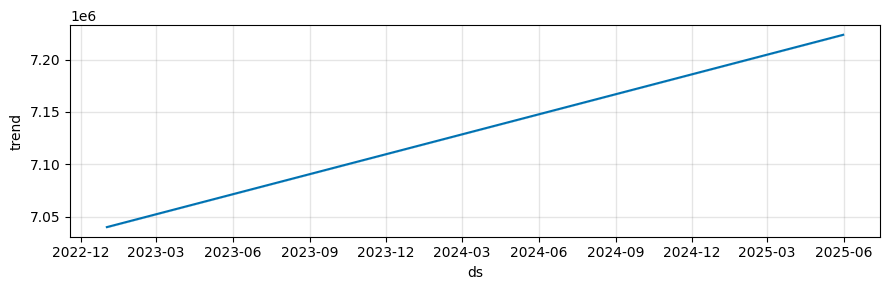

In [19]:
# Sales Forecasting using Prophet

# Prophet requires the time series data to be in a DataFrame with 'ds' and 'y' columns.
# 'ds' should be a datetime column and 'y' should be the value to forecast.

# Use the monthly sales aggregation created earlier
prophet_df = monthly_sales_agg.reset_index()
prophet_df.columns = ['ds', 'y']

# Convert 'ds' to datetime objects
prophet_df['ds'] = prophet_df['ds'].dt.to_timestamp()

# Initialize and fit the Prophet model
model = Prophet()
model.fit(prophet_df)

# Create a future dataframe for forecasting (e.g., next 6 months)
future = model.make_future_dataframe(periods=6, freq='M')

# Make predictions
forecast = model.predict(future)

# Display the forecast
print("\nSales Forecast for the next 6 months:")
display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# Plot the forecast
fig = model.plot(forecast)
plt.title('Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Predicted Sales')
plt.show()

# Plot the components of the forecast (trend, seasonality)
fig2 = model.plot_components(forecast)
plt.show()